#### 폰트 설정 및 라이브러리 설치

In [1]:
# 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r"D:\nanum-all\나눔 글꼴\나눔바른고딕\NanumFontSetup_TTF_BARUNGOTHIC\NanumBarunGothic.ttf", # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

zsh:1: command not found: apt-get


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# 서울시 상권분석 서비스에서 전처리 한 최종 데이터 파일 last.csv 파일 불러오기
# 군집화 완료한 cluster1부터 cluster5까지 불러오기

In [3]:
a = pd.read_csv('last.csv')

cluster1 = pd.read_csv('cluster1.csv')
cluster2 = pd.read_csv('cluster2.csv')
cluster3 = pd.read_csv('cluster3.csv')
cluster4 = pd.read_csv('cluster4.csv')
cluster5 = pd.read_csv('cluster5.csv')

# 모델링에 사용할 데이터 전처리

In [4]:
remove_codes = [2110065, 2110164, 2110116, 2110788, 2110131, 2110137]
a = a[~a['상권_코드'].isin(remove_codes)]

# 각 상권 코드별로 데이터프레임 생성하고 'a'와 내부 조인(inner join)으로 병합
data_df1 = pd.merge(a, cluster1[['상권_코드']], on='상권_코드', how='inner')
data_df2 = pd.merge(a, cluster2[['상권_코드']], on='상권_코드', how='inner')
data_df3 = pd.merge(a, cluster3[['상권_코드']], on='상권_코드', how='inner')
data_df4 = pd.merge(a, cluster4[['상권_코드']], on='상권_코드', how='inner')
data_df5 = pd.merge(a, cluster5[['상권_코드']], on='상권_코드', how='inner')

# 각 병합된 데이터프레임의 형태(shape) 가져오기
shapes = {
    "data_df1": data_df1.shape,
    "data_df2": data_df2.shape,
    "data_df3": data_df3.shape,
    "data_df4": data_df4.shape,
    "data_df5": data_df5.shape
}


In [5]:
# 다섯 개의 클러스터 데이터프레임을 리스트에 저장
data_dfs = [data_df1, data_df2, data_df3, data_df4, data_df5]

# 새로운 열 추가
for df in data_dfs:
    df['교통시설_수'] = df['지하철_역_수'] + df['버스_정거장_수'] + df['공항_수'] + df['철도_역_수'] + df['버스_터미널_수']
    df['학교수'] = df['유치원_수'] + df['초등학교_수'] + df['중학교_수'] + df['고등학교_수'] + df['대학교_수']
    df['편의시설_수'] = df['은행_수'] + df['종합병원_수'] + df['일반_병원_수'] + df['약국_수']  + df['백화점_수'] + df['슈퍼마켓_수'] + df['극장_수']

# 제거할 열 정의
cols_to_drop = ['지하철_역_수','버스_정거장_수','공항_수','철도_역_수','버스_터미널_수','집객시설_수',
                '관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수','유치원_수', '초등학교_수', '중학교_수', '고등학교_수','대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수']

# 지정된 열을 제거
for df in data_dfs:
    df.drop(cols_to_drop, axis=1, inplace=True)

# 변경 사항을 확인하기 위해 하나의 데이터프레임(data_df1)의 처음 몇 개 행을 출력
data_df1.head()


,상권_코드,월_평균_소득_금액,소득_구간_코드,운영_영업_개월_평균,폐업_영업_개월_평균,서울_운영_영업_개월_평균,서울_폐업_영업_개월_평균,총_상주인구_수,남성_상주인구_수,여성_상주인구_수,...,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,교통시설_수,학교수,편의시설_수
0,2110002,3.363814e+06,7.0000,131.3750,60.9375,110.1875,53.5625,637.1875,308.1875,329.0000,...,887.768065,6381.697933,5654.243959,6618.587135,6446.506474,5148.741909,8.177261,4.000,0.0000,4.6875
1,2110050,2.732574e+06,6.0000,104.9375,53.3125,110.1875,53.5625,832.1875,394.3750,437.8125,...,66.595788,1189.954739,1625.612662,1716.701980,1683.003274,1659.004780,5.190012,2.250,0.3125,1.9375
2,2110052,2.432743e+06,5.3125,120.1250,62.9375,110.1875,53.5625,1773.6250,894.1250,879.5000,...,68.909111,1474.135441,1696.147985,1755.657177,1950.869418,1456.847616,5.737197,1.000,0.0000,4.6875
3,2110066,2.522702e+06,5.8750,115.3750,62.8750,110.1875,53.5625,2798.3125,1429.8125,1368.5000,...,232.450316,4076.039932,4680.664014,4031.492731,3296.793523,1431.195495,8.066553,2.625,0.0000,3.3750
4,2110071,5.129353e+06,9.0000,142.2500,67.1250,110.1875,53.5625,217.6250,95.5625,122.0625,...,165.463724,1280.637545,3565.751632,4615.386383,3178.483269,3153.353035,6.672795,1.000,0.0000,8.3750


In [6]:
# 모든 열을 표시하도록 Pandas 설정을 변경
pd.set_option('display.max_columns', None)


In [7]:
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler를 다시 초기화하고 각 데이터프레임을 스케일링
scaler = MinMaxScaler()

def scale_dataframe(df):
    # '상권_코드'를 제외한 열을 스케일링
    columns_to_scale = df.columns.difference(['상권_코드'])
    scaled_data = scaler.fit_transform(df[columns_to_scale])
    
    # 스케일링된 데이터로 새로운 데이터프레임을 생성
    new_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
    new_df['상권_코드'] = df['상권_코드']
    return new_df

# 각 데이터프레임에 스케일링 함수를 적용
new_data_df1 = scale_dataframe(data_df1)
new_data_df2 = scale_dataframe(data_df2)
new_data_df3 = scale_dataframe(data_df3)
new_data_df4 = scale_dataframe(data_df4)
new_data_df5 = scale_dataframe(data_df5)

# 스케일링된 데이터프레임 new_data_df1을 예시로 표시
new_data_df1.head()


,1년생존율,1층_임대료,1층외_임대료,3년생존율,5년생존율,개업_율,개업_점포_수,교육_amount,교육_prob,교통시설_수,금요일_매출_건수,금요일_매출_금액,금요일_매출_비율,금요일_생활인구_수,기타_개인_서비스_amount,기타_개인_서비스_prob,남성_매출_건수,남성_매출_금액,남성_매출_비율,남성_상주인구_수,남성_생활인구_수,남성_직장_인구_수,남성연령대_10_상주인구_수,남성연령대_10_직장_인구_수,남성연령대_20_상주인구_수,남성연령대_20_직장_인구_수,남성연령대_30_상주인구_수,남성연령대_30_직장_인구_수,남성연령대_40_상주인구_수,남성연령대_40_직장_인구_수,남성연령대_50_상주인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_상주인구_수,남성연령대_60_이상_직장_인구_수,목요일_매출_건수,목요일_매출_금액,목요일_매출_비율,목요일_생활인구_수,보건_amount,보건_prob,분기당_매출_건수,분기당_매출_금액,비_아파트_가구_수,서울_운영_영업_개월_평균,서울_폐업_영업_개월_평균,소득_구간_코드,소매업_amount,소매업_prob,수요일_매출_건수,수요일_매출_금액,수요일_매출_비율,수요일_생활인구_수,스포츠_및_오락관련_서비스업_amount,스포츠_및_오락관련_서비스업_prob,시간대_00~06_매출_금액,시간대_00~06_매출_비율,시간대_06~11_매출_금액,시간대_06~11_매출_비율,시간대_11~14_매출_금액,시간대_11~14_매출_비율,시간대_14~17_매출_금액,시간대_14~17_매출_비율,시간대_17~21_매출_금액,시간대_17~21_매출_비율,시간대_1_생활인구_수,시간대_21~24_매출_금액,시간대_21~24_매출_비율,시간대_2_생활인구_수,시간대_3_생활인구_수,시간대_4_생활인구_수,시간대_5_생활인구_수,시간대_6_생활인구_수,시간대_건수~06_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,식료품_amount,식료품_prob,아파트_가구_수,여성_매출_건수,여성_매출_금액,여성_매출_비율,여성_상주인구_수,여성_생활인구_수,여성_직장_인구_수,여성연령대_10_상주인구_수,여성연령대_10_직장_인구_수,여성연령대_20_상주인구_수,여성연령대_20_직장_인구_수,여성연령대_30_상주인구_수,여성연령대_30_직장_인구_수,여성연령대_40_상주인구_수,여성연령대_40_직장_인구_수,여성연령대_50_상주인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_상주인구_수,여성연령대_60_이상_직장_인구_수,연령대_10_매출_건수,연령대_10_매출_금액,연령대_10_매출_비율,연령대_10_상주인구_수,연령대_10_생활인구_수,연령대_10_직장_인구_수,연령대_20_매출_건수,연령대_20_매출_금액,연령대_20_매출_비율,연령대_20_상주인구_수,연령대_20_생활인구_수,연령대_20_직장_인구_수,연령대_30_매출_건수,연령대_30_매출_금액,연령대_30_매출_비율,연령대_30_상주인구_수,연령대_30_생활인구_수,연령대_30_직장_인구_수,연령대_40_매출_건수,연령대_40_매출_금액,연령대_40_매출_비율,연령대_40_상주인구_수,연령대_40_생활인구_수,연령대_40_직장_인구_수,연령대_50_매출_건수,연령대_50_매출_금액,연령대_50_매출_비율,연령대_50_상주인구_수,연령대_50_생활인구_수,연령대_50_직장_인구_수,연령대_60_이상_매출_건수,연령대_60_이상_매출_금액,연령대_60_이상_매출_비율,연령대_60_이상_상주인구_수,연령대_60_이상_생활인구_수,연령대_60_이상_직장_인구_수,운영_영업_개월_평균,월_평균_소득_금액,월요일_매출_건수,월요일_매출_금액,월요일_매출_비율,월요일_생활인구_수,유사_업종_점포_수,음료_amount,음료_prob,음식점_amount,음식점_prob,의류_미용_amount,의류_미용_prob,일요일_매출_건수,일요일_매출_금액,일요일_매출_비율,일요일_생활인구_수,전체_임대료,점포_수,점포수,주말_매출_건수,주말_매출_금액,주말_매출_비율,주점업_amount,주점업_prob,주중_매출_건수,주중_매출_금액,주중_매출_비율,총_가구_수,총_상주인구_수,총_생활인구_수,총_직장_인구_수,토요일_매출_건수,토요일_매출_금액,토요일_매출_비율,토요일_생활인구_수,편의시설_수,폐업_률,폐업_영업_개월_평균,폐업_점포_수,프랜차이즈_점포_수,학교수,화요일_매출_건수,화요일_매출_금액,화요일_매출_비율,화요일_생활인구_수,상권_코드
0,0.259864,0.100017,0.000000,0.502781,0.470452,0.308556,0.117941,0.321943,0.151671,0.285714,0.902684,0.491411,0.433400,0.060300,0.035430,0.018405,0.866090,0.554416,0.614948,0.047352,0.057206,0.016866,0.048144,0.032847,0.014706,0.034451,0.018367,0.016999,0.051491,0.019309,0.048038,0.005812,0.076351,0.022084,0.881513,0.498909,0.332069,0.061589,0.129660,0.211796,0.922983,0.552083,0.041362,1.0,1.0,0.594937,0.239864,0.492701,0.914571,0.556346,0.334594,0.061235,0.114093,0.092486,0.241635,0.298766,0.268891,0.526941,0.325336,0.389890,0.353120,0.447065,0.560279,0.515611,0.047410,0.329734,0.386808,0.061209,0.070333,0.072590,0.061842,0.056678,0.471901,0.971828,0.693069,0.669485,0.702270,0.775975,0.426244,0.559242,0.035095,0.659034,0.530477,0.384156,0.049068,0.059434,0.137827,0.051501,0.004484,0.012836,0.144459,0.021166,0.157877,0.039923,0.112541,0.046530,0.066831,0.087207,0.057893,0.462193,0.271240,0.282130,0.049740,0.092210,0.024272,0.534695,0.427741,0.278976,0.013472,0.027638,0.098814,0.618986,0.411679,0.114298,0.019686,0.030669,0.067313,0.870886,0.501025,0.571840,0.044769,0.069505,0.049731,1.000000,0.422392,0.641850,0.048092,0.072782,0.018720,0.555563,0.459371,0.633187,0.083532,0.080997,0.038231,0.746072,0.343818,0.934281,0.349307,0.286891,0.059287,0.283712,0.066760,0.045802,0.078289,0.130435,0.083319,0.069948,0.550490,0.301894,0.570314,0.052621,0.150001,0.267578,0.331098,0.595363,0.563077,0.758702,0.271449,0.263374,0.911689,0.490950,0.240188,0.043170,0.048234,0.058394,0.054321,0.642357,0.634901,0.774391,0.053516,0.358852,0.359235,0.663823,0.309854,0.281957,0.000000,0.926608,0.556903,0.413723,0.060992,2110002
1,0.956463,0.391837,0.379468,0.880979,0.906141,0.529088,0.134739,0.004379,0.012853,0.160714,0.212596,0.087371,0.677268,0.0696

In [8]:
# 선택할 열을 정의
selected_columns = ['주중_매출_금액', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주말_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수']

# 각 데이터프레임에 열 선택을 적용
new_data_df1 = new_data_df1[selected_columns]
new_data_df2 = new_data_df2[selected_columns]
new_data_df3 = new_data_df3[selected_columns]
new_data_df4 = new_data_df4[selected_columns]
new_data_df5 = new_data_df5[selected_columns]

# 업데이트된 데이터프레임 new_data_df1의 처음 몇 개 행을 표시
new_data_df1.head()


,주중_매출_금액,남성연령대_10_상주인구_수,남성연령대_20_상주인구_수,남성연령대_30_상주인구_수,남성연령대_40_상주인구_수,남성연령대_50_상주인구_수,남성연령대_60_이상_상주인구_수,여성연령대_10_상주인구_수,여성연령대_20_상주인구_수,여성연령대_30_상주인구_수,여성연령대_40_상주인구_수,여성연령대_50_상주인구_수,여성연령대_60_이상_상주인구_수,남성연령대_10_직장_인구_수,남성연령대_20_직장_인구_수,남성연령대_30_직장_인구_수,남성연령대_40_직장_인구_수,남성연령대_50_직장_인구_수,남성연령대_60_이상_직장_인구_수,여성연령대_10_직장_인구_수,여성연령대_20_직장_인구_수,여성연령대_30_직장_인구_수,여성연령대_40_직장_인구_수,여성연령대_50_직장_인구_수,여성연령대_60_이상_직장_인구_수,전체_임대료,점포_수,유사_업종_점포_수,프랜차이즈_점포_수,주말_매출_건수,시간대_건수~06_매출_건수,시간대_건수~11_매출_건수,시간대_건수~14_매출_건수,시간대_건수~17_매출_건수,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,교통시설_수
0,0.490950,0.048144,0.014706,0.018367,0.051491,0.048038,0.076351,0.051501,0.012836,0.021166,0.039923,0.046530,0.087207,0.032847,0.034451,0.016999,0.019309,0.005812,0.022084,0.004484,0.144459,0.157877,0.112541,0.066831,0.057893,0.150001,0.267578,0.283712,0.281957,0.595363,0.471901,0.971828,0.693069,0.669485,0.702270,0.775975,0.285714
1,0.082466,0.057480,0.047391,0.034867,0.076055,0.049425,0.067803,0.053352,0.036728,0.043727,0.069140,0.061467,0.085991,0.003650,0.030684,0.028683,0.022740,0.014699,0.039807,0.000000,0.029445,0.040311,0.020975,0.028439,0.038317,0.347372,0.191389,0.181643,0.096439,0.125432,0.076163,0.205539,0.195402,0.140462,0.167792,0.147635,0.160714
2,0.142305,0.123496,0.101186,0.097388,0.144481,0.174130,0.151981,0.126821,0.095270,0.076894,0.141997,0.157369,0.144021,0.000000,0.028388,0.040221,0.039429,0.028189,0.062355,0.044843,0.043943,0.064048,0.078170,0.102095,0.150354,0.216775,0.296295,0.286228,0.110133,0.110733,0.042846,0.202038,0.246981,0.155603,0.184010,0.129933,0.071429
3,0.281516,0.171128,0.159677,0.156219,0.263102,0.305005,0.239520,0.163113,0.116157,0.138531,0.236042,0.261732,0.251043,0.233577,0.128893,0.099334,0.062917,0.027956,0.179178,0.197309,0.090053,0.117393,0.084075,0.104939,0.083299,0.225434,0.373467,0.391060,0.307768,0.347108,0.481107,0.506331,0.458529,0.270106,0.364366,0.553290,0.187500
4,0.429245,0.016850,0.004886,0.009287,0.008544,0.005754,0.010372,0.030498,0.002708,0.008466,0.021783,0.010707,0.017587,0.000000,0.027102,0.021257,0.016969,0.011517,0.048993,0.040359,0.030416,0.041001,0.033313,0.023604,0.057060,0.756408,0.251103,0.264129,0.258569,0.311093,0.097631,0.435215,0.469226,0.415643,0.336409,0.235902,0.071429


# 의사결정트리

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

def get_classification_report(df):
    # 특성과 타겟 변수 선택
    y = df['주중_매출_금액']
    X = df.drop(columns=['주중_매출_금액'])

    # '주중_매출_금액'을 세 가지 범주로 변환
    lower_bound = y.quantile(0.33)
    upper_bound = y.quantile(0.66)
    y = y.apply(lambda x: 0 if x <= lower_bound else (1 if x <= upper_bound else 2))

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # DecisionTree 모델 생성 및 훈련
    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train, y_train)

    # 예측 및 분류 보고서 생성
    y_pred = dt_model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    # 분류 보고서를 데이터프레임으로 변환하여 출력을 개선
    report_df = pd.DataFrame(report).transpose()

    return report_df

# '주중_매출_금액'을 타겟 변수로 하는 분류 보고서 생성
all_reports_weekday = []

for i, df in enumerate([new_data_df1, new_data_df2, new_data_df3, new_data_df4, new_data_df5], start=1):
    report_df = get_classification_report(df)
    report_df['DataFrame'] = f"data_df{i}"
    all_reports_weekday.append(report_df)

# 모든 보고서를 하나의 데이터프레임으로 연결
final_report_weekday_df = pd.concat(all_reports_weekday, axis=0).reset_index().rename(columns={'index': 'Metric'})
final_report_weekday_df = final_report_weekday_df[['DataFrame', 'Metric', 'precision', 'recall', 'f1-score', 'support']]

final_report_weekday_df



,DataFrame,Metric,precision,recall,f1-score,support
0,data_df1,0,0.785714,0.733333,0.758621,15.000000
1,data_df1,1,0.800000,0.666667,0.727273,12.000000
2,data_df1,2,0.666667,0.888889,0.761905,9.000000
3,data_df1,accuracy,0.750000,0.750000,0.750000,0.750000
4,data_df1,macro avg,0.750794,0.762963,0.749266,36.000000
5,data_df1,weighted avg,0.760714,0.750000,0.748992,36.000000
6,data_df2,0,0.666667,0.666667,0.666667,6.000000
7,data_df2,1,0.500000,0.428571,0.461538,7.000000
8,data_df2,2,0.571429,0.666667,0.615385,6.000000
9,data_df2,accuracy,0.578947,0.578947,0.578947,0.578947


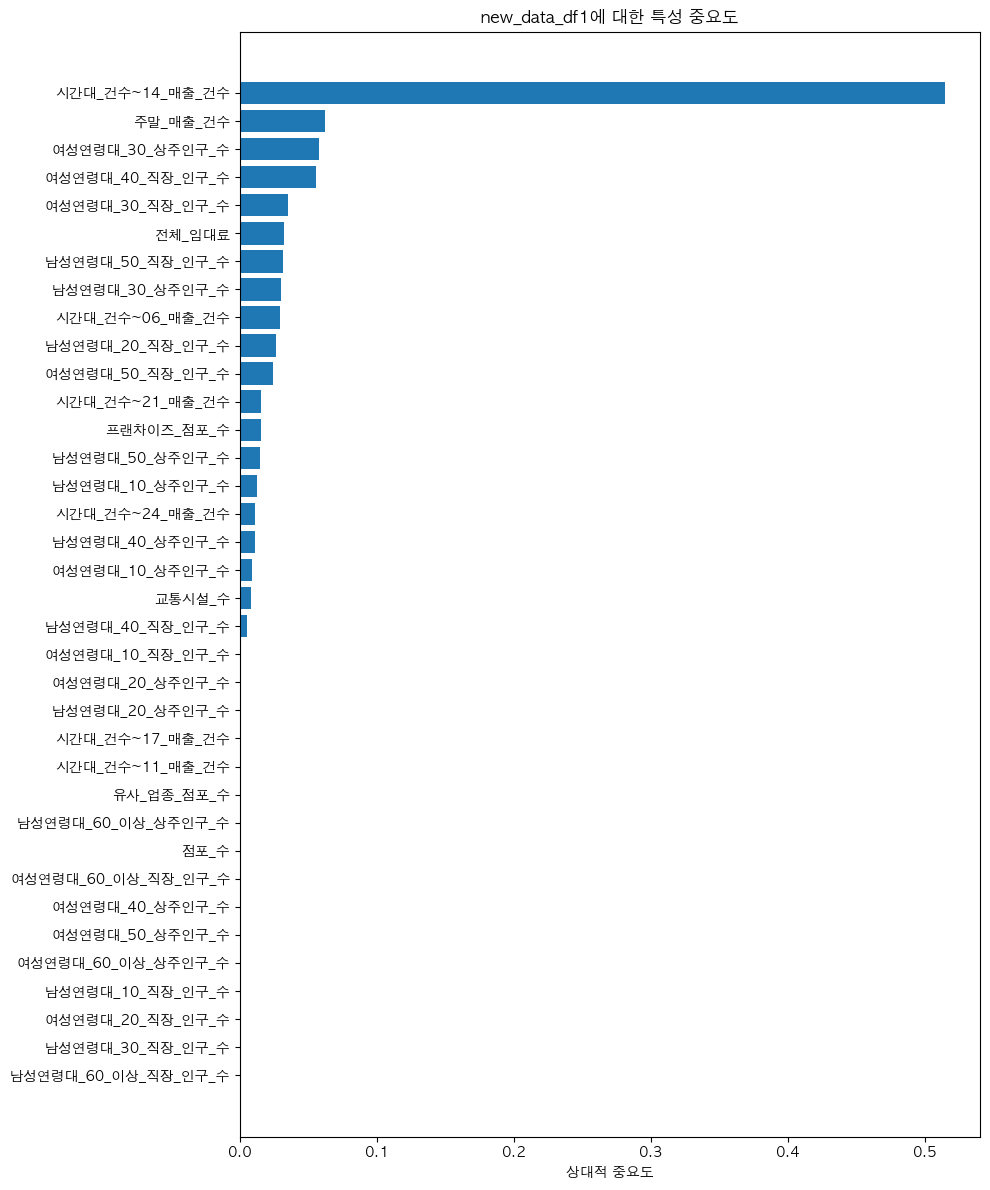

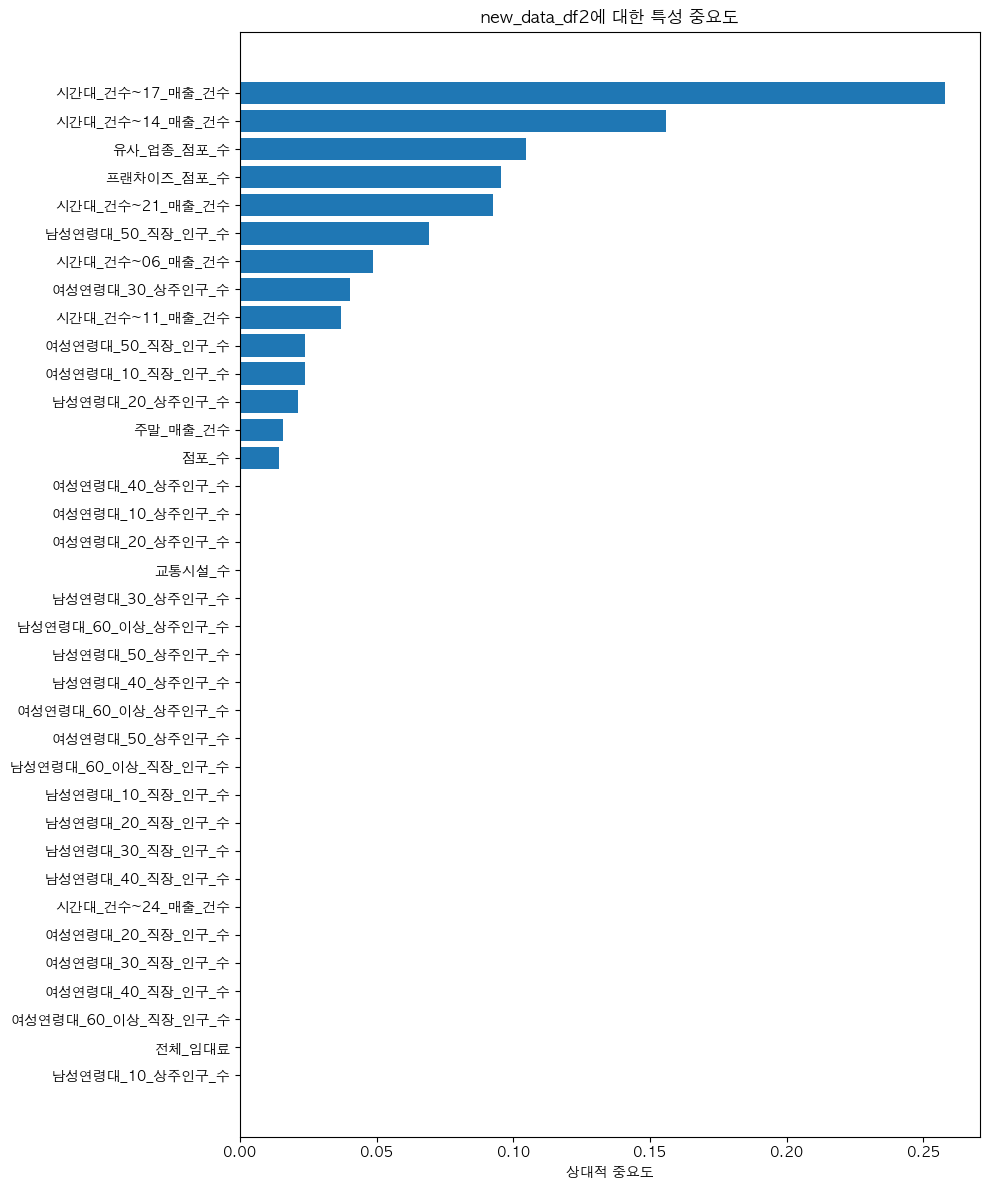

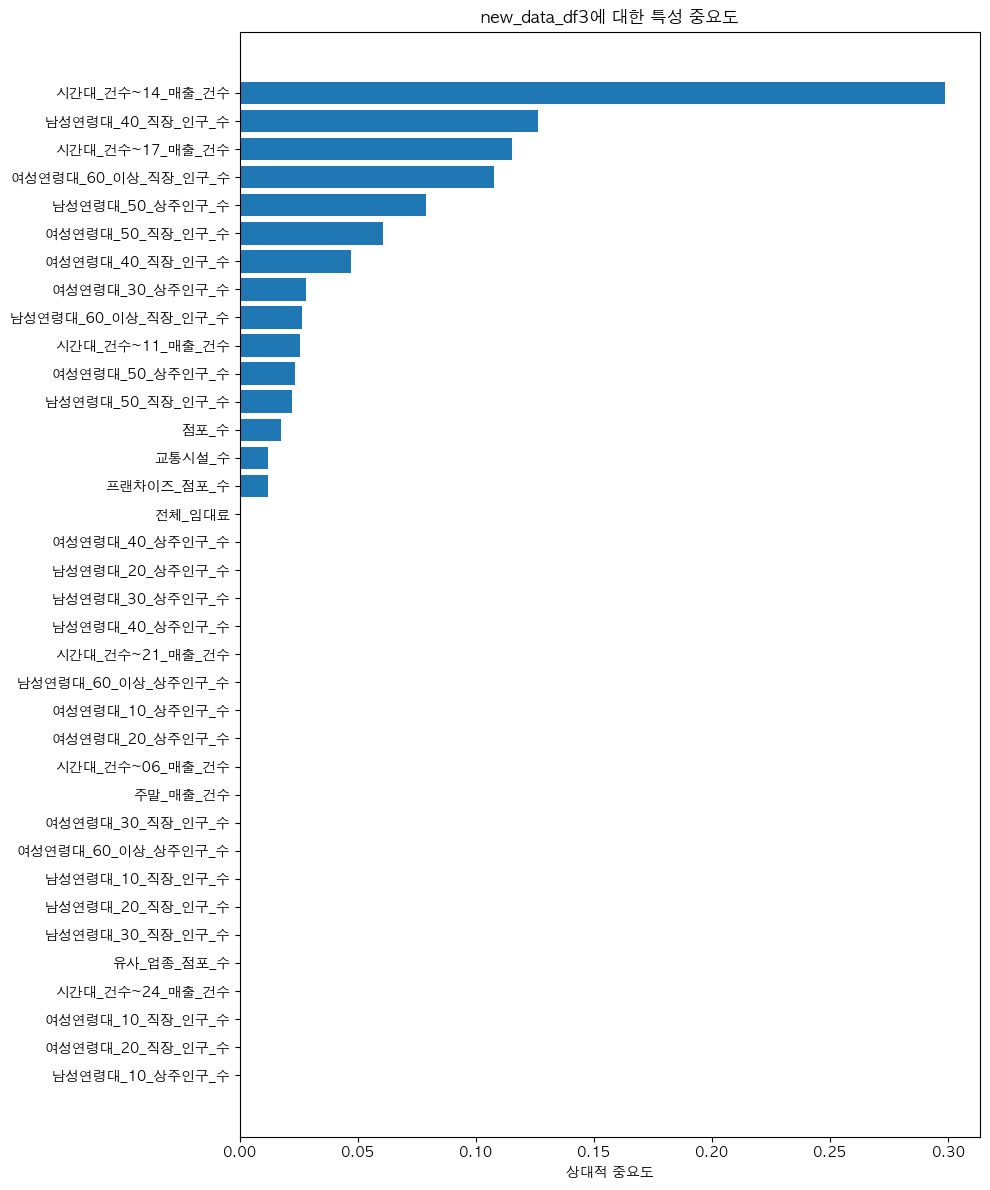

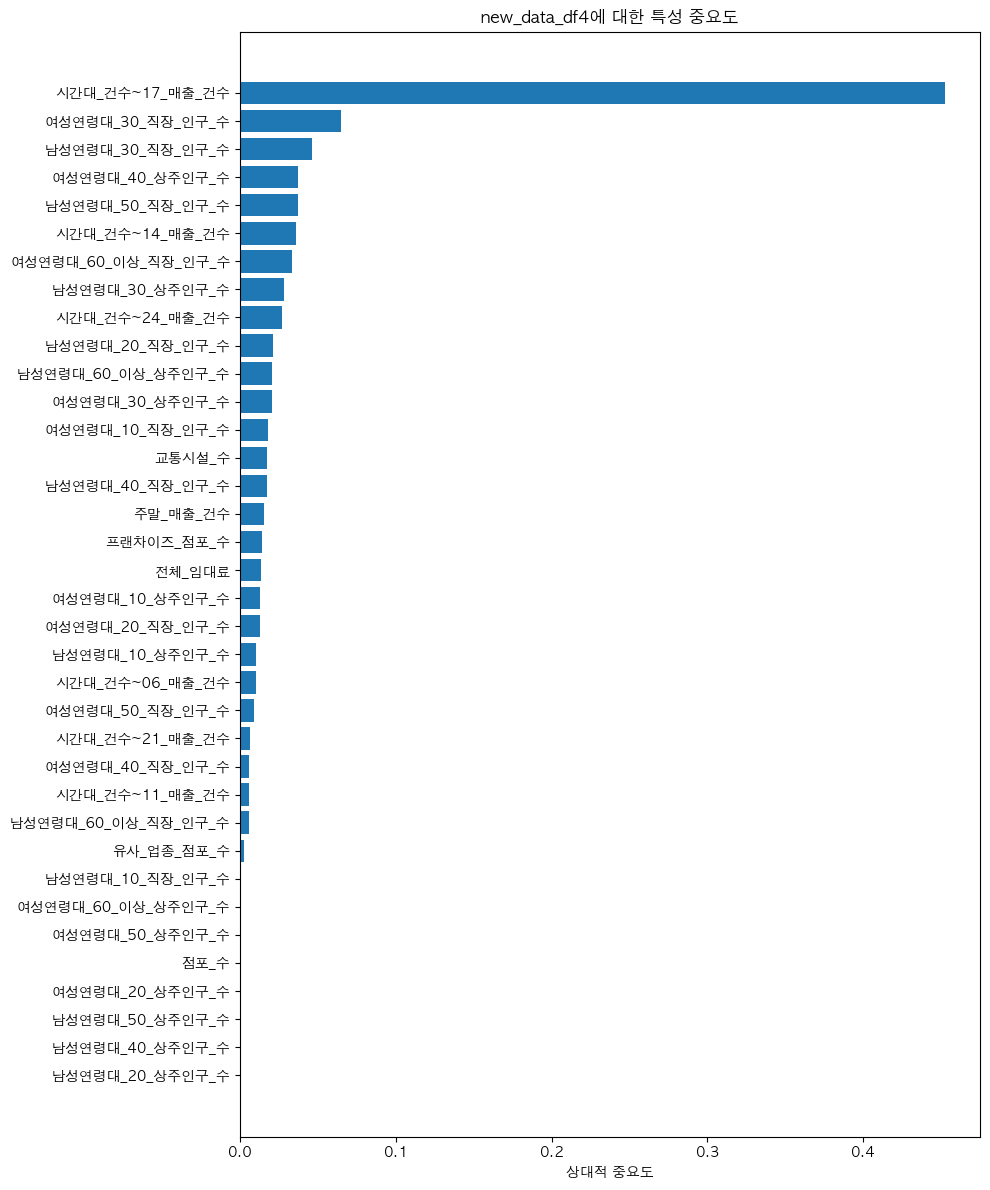

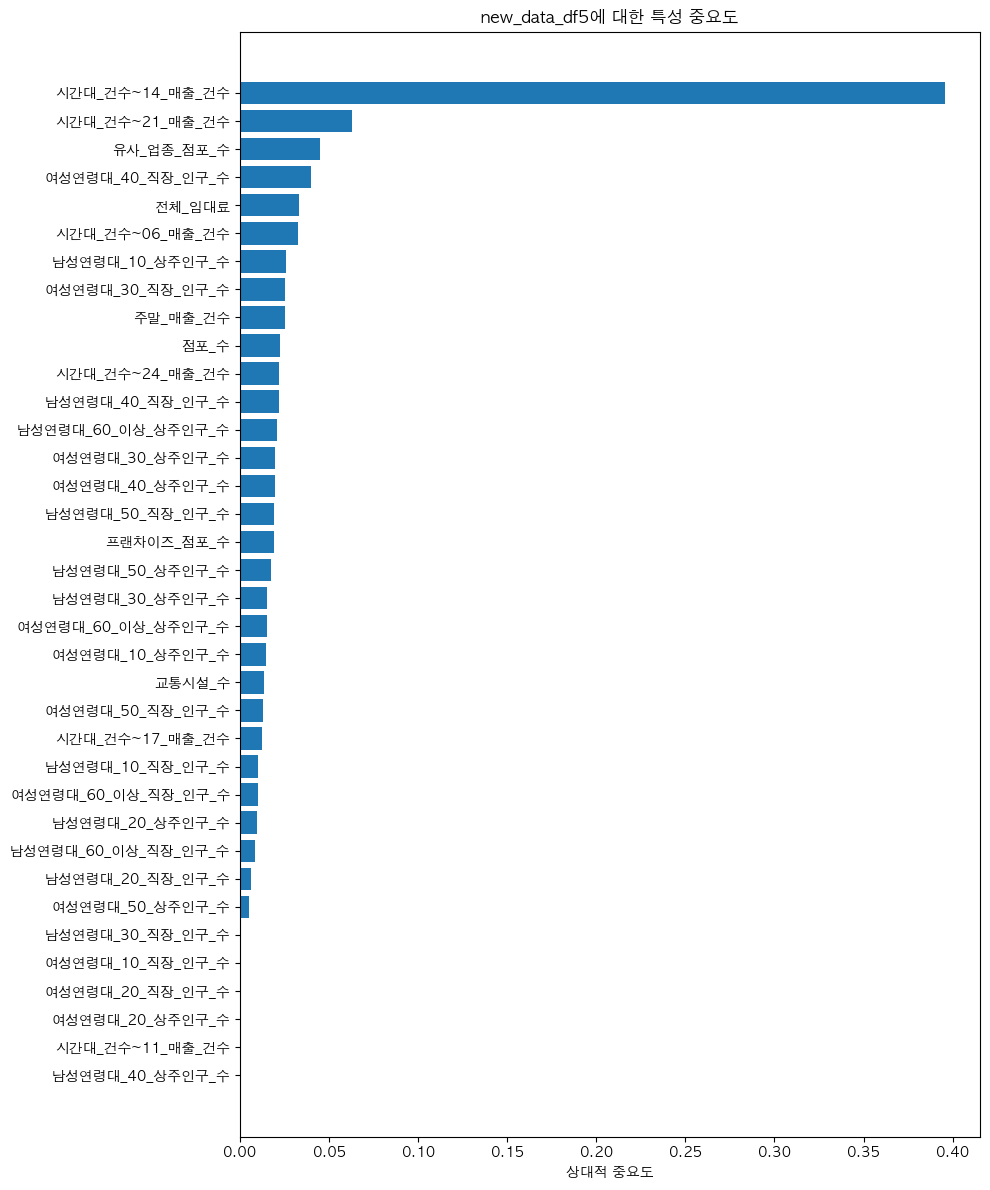

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(df, model, title):
    # 특성 중요도 가져오기
    importances = model.feature_importances_
    # 열 이름 가져오기
    columns = df.drop(columns=['주중_매출_금액']).columns
    # 중요도 정렬
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 12))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [columns[i] for i in indices])
    plt.xlabel('상대적 중요도')
    plt.tight_layout()
    plt.show()

# 각 데이터프레임에 대해 모델을 훈련하고 특성 중요도를 시각화
models = []
for i, df in enumerate([new_data_df1, new_data_df2, new_data_df3, new_data_df4, new_data_df5], start=1):
    y = df['주중_매출_금액']
    lower_bound = y.quantile(0.33)
    upper_bound = y.quantile(0.66)
    y = y.apply(lambda x: 0 if x <= lower_bound else (1 if x <= upper_bound else 2))
    X = df.drop(columns=['주중_매출_금액'])

    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X, y)
    models.append(dt_model)

    plot_feature_importance(df, dt_model, f"new_data_df{i}에 대한 특성 중요도")


# 의사결정트리(그리드 서치를 통한 하이퍼 파라미터 조정)

In [11]:
from sklearn.model_selection import GridSearchCV

def get_optimized_classification_report(df):
    # 특성과 목표 변수 선택
    y = df['주중_매출_금액']
    X = df.drop(columns=['주중_매출_금액'])

    # '주중_매출_금액'을 세 개의 범주로 변환
    lower_bound = y.quantile(0.33)
    upper_bound = y.quantile(0.66)
    y = y.apply(lambda x: 0 if x <= lower_bound else (1 if x <= upper_bound else 2))

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 의사 결정 트리 모델 생성
    dt_model = DecisionTreeClassifier(random_state=42)

    # 그리드 서치용 매개변수 그리드 정의
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # GridSearchCV 객체 생성
    grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # 데이터에 맞게 학습
    grid_search.fit(X_train, y_train)

    # 그리드 서치에서 최적의 추정기를 사용하여 예측
    best_dt_model = grid_search.best_estimator_
    y_pred = best_dt_model.predict(X_test)

    # 분류 보고서 가져오기
    report = classification_report(y_test, y_pred, output_dict=True)

    # 분류 보고서를 데이터프레임으로 변환하여 표시하기 좋게 함
    report_df = pd.DataFrame(report).transpose()

    return report_df

# 주중_매출_금액을 목표 변수로 한 그리드 서치 최적화 분류 보고서 가져오기
all_reports_weekday_optimized = []

for i, df in enumerate([new_data_df1, new_data_df2, new_data_df3, new_data_df4, new_data_df5], start=1):
    report_df = get_optimized_classification_report(df)
    report_df['DataFrame'] = f"data_df{i}"
    all_reports_weekday_optimized.append(report_df)

# 모든 보고서를 하나의 데이터프레임으로 연결
final_report_weekday_optimized_df = pd.concat(all_reports_weekday_optimized, axis=0).reset_index().rename(columns={'index': 'Metric'})
final_report_weekday_optimized_df = final_report_weekday_optimized_df[['DataFrame', 'Metric', 'precision', 'recall', 'f1-score', 'support']]

final_report_weekday_optimized_df



,DataFrame,Metric,precision,recall,f1-score,support
0,data_df1,0,0.800000,0.800000,0.800000,15.000000
1,data_df1,1,0.769231,0.833333,0.800000,12.000000
2,data_df1,2,0.875000,0.777778,0.823529,9.000000
3,data_df1,accuracy,0.805556,0.805556,0.805556,0.805556
4,data_df1,macro avg,0.814744,0.803704,0.807843,36.000000
5,data_df1,weighted avg,0.808494,0.805556,0.805882,36.000000
6,data_df2,0,0.714286,0.833333,0.769231,6.000000
7,data_df2,1,0.600000,0.428571,0.500000,7.000000
8,data_df2,2,0.571429,0.666667,0.615385,6.000000
9,data_df2,accuracy,0.631579,0.631579,0.631579,0.631579


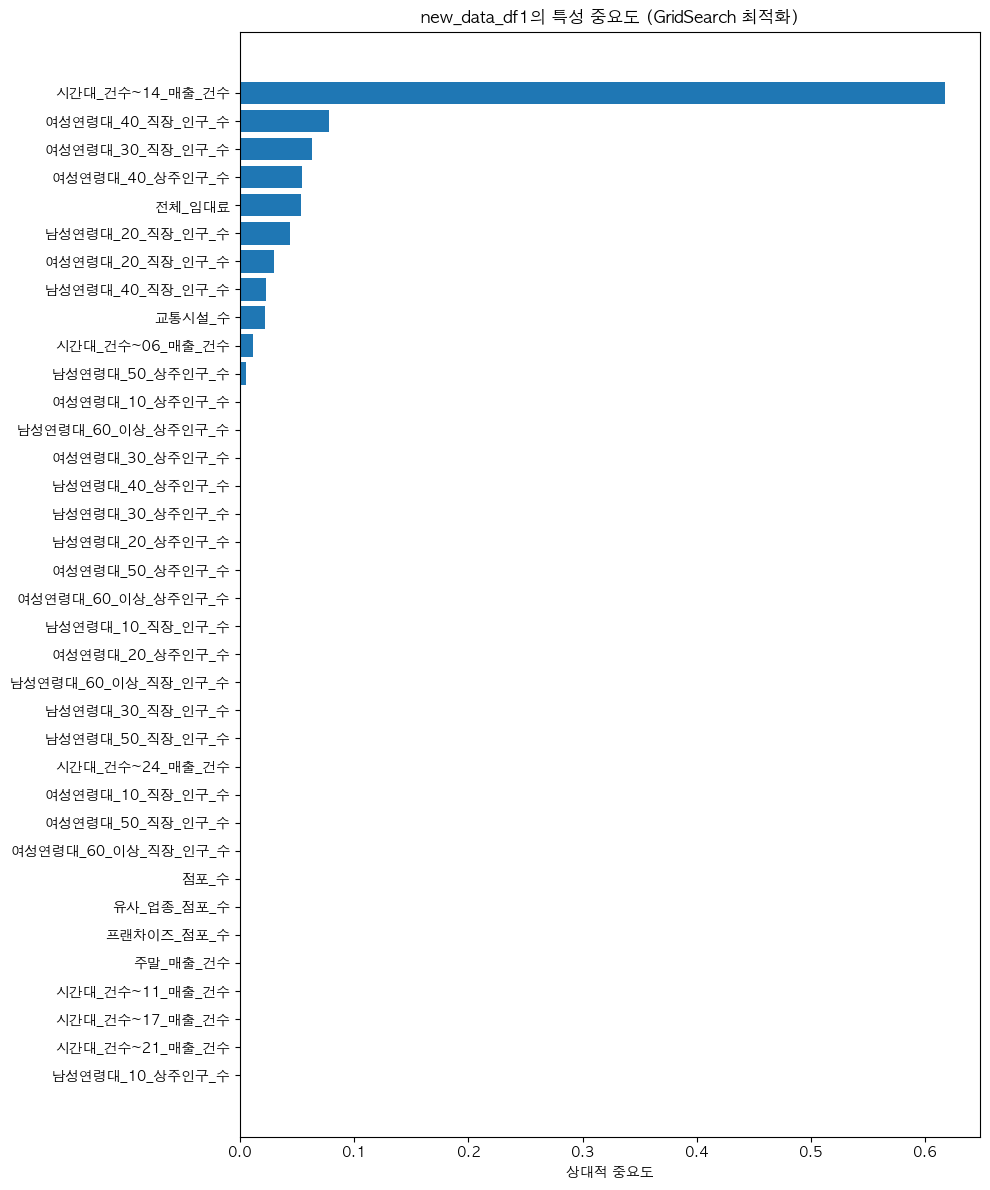

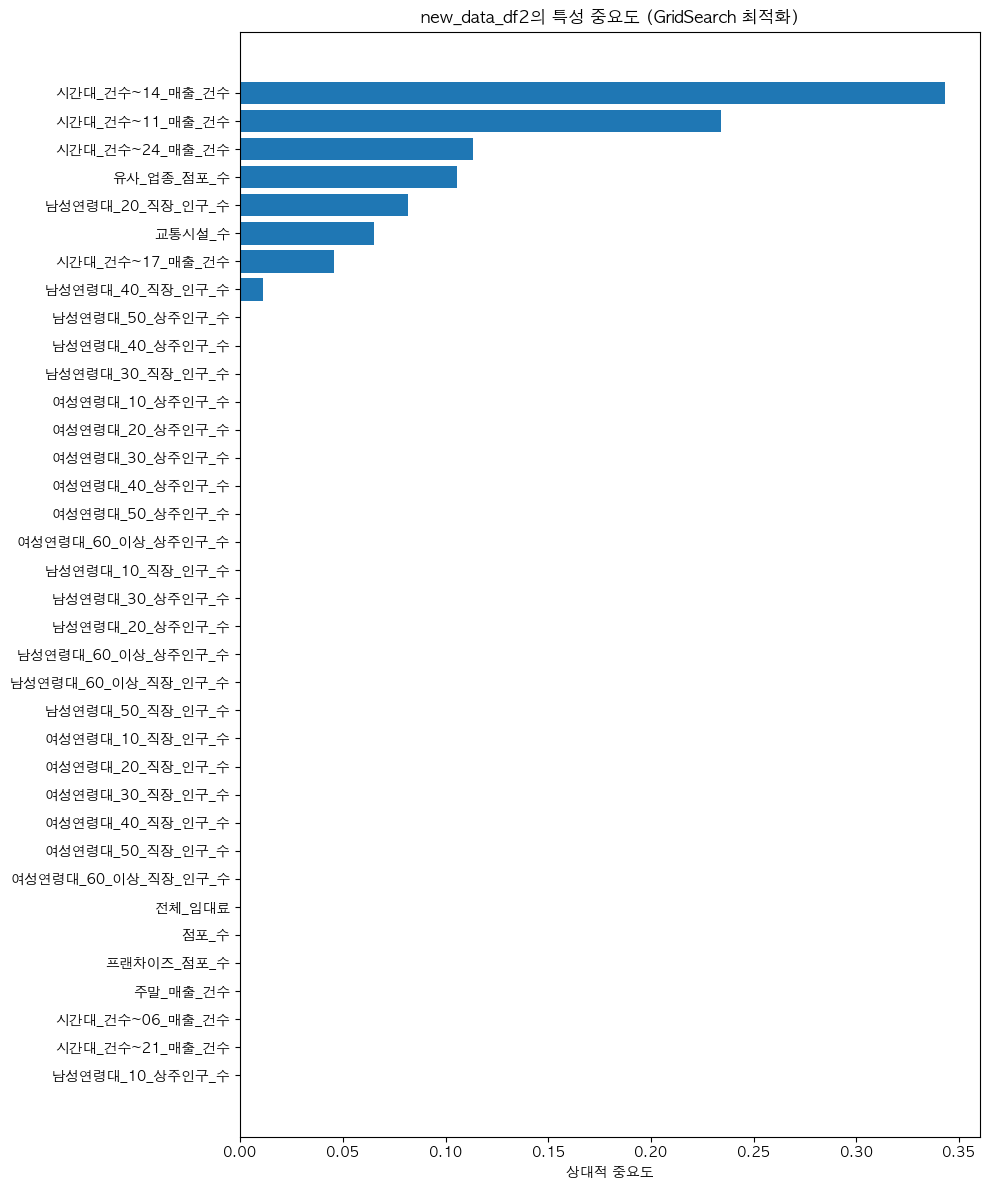

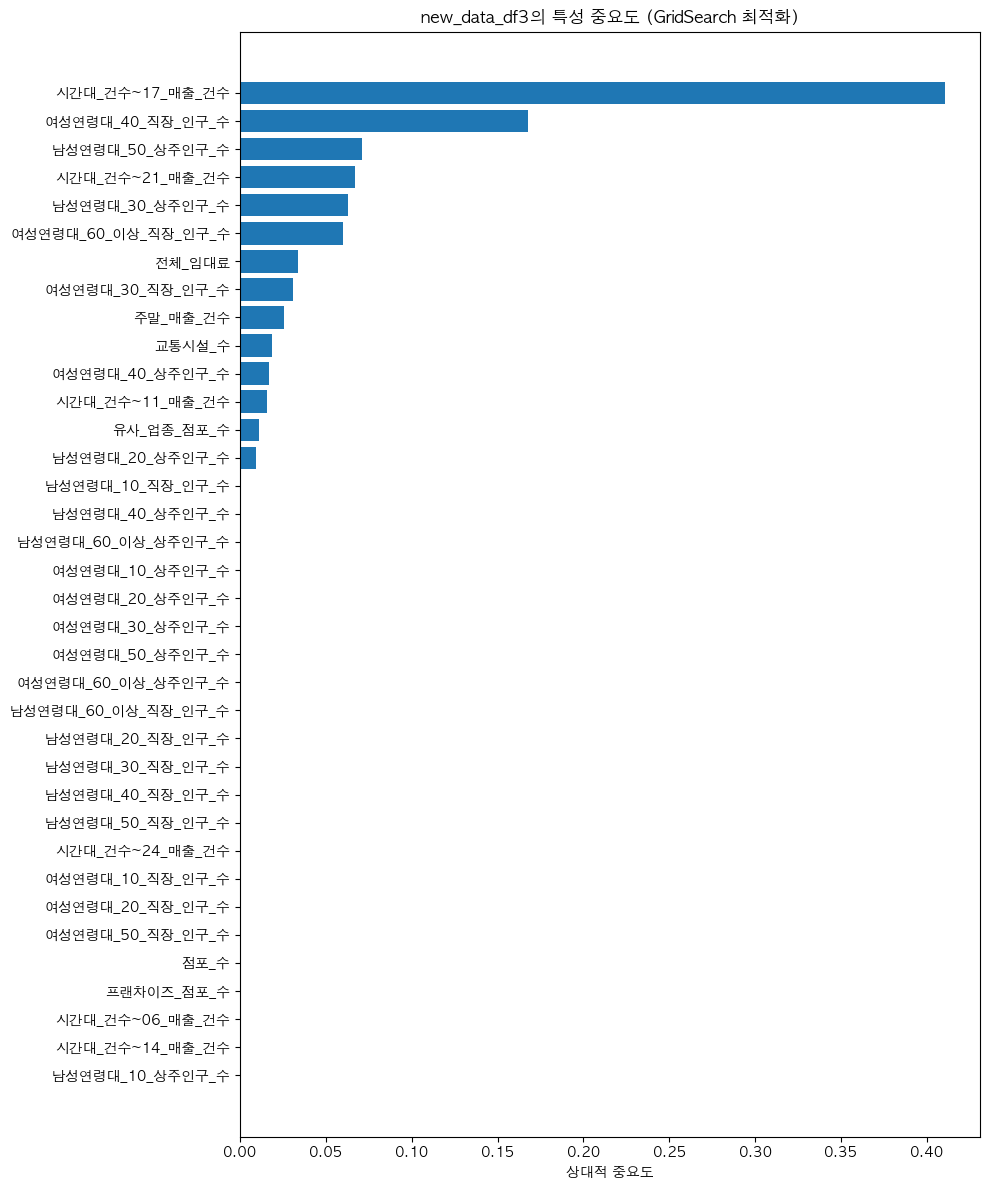

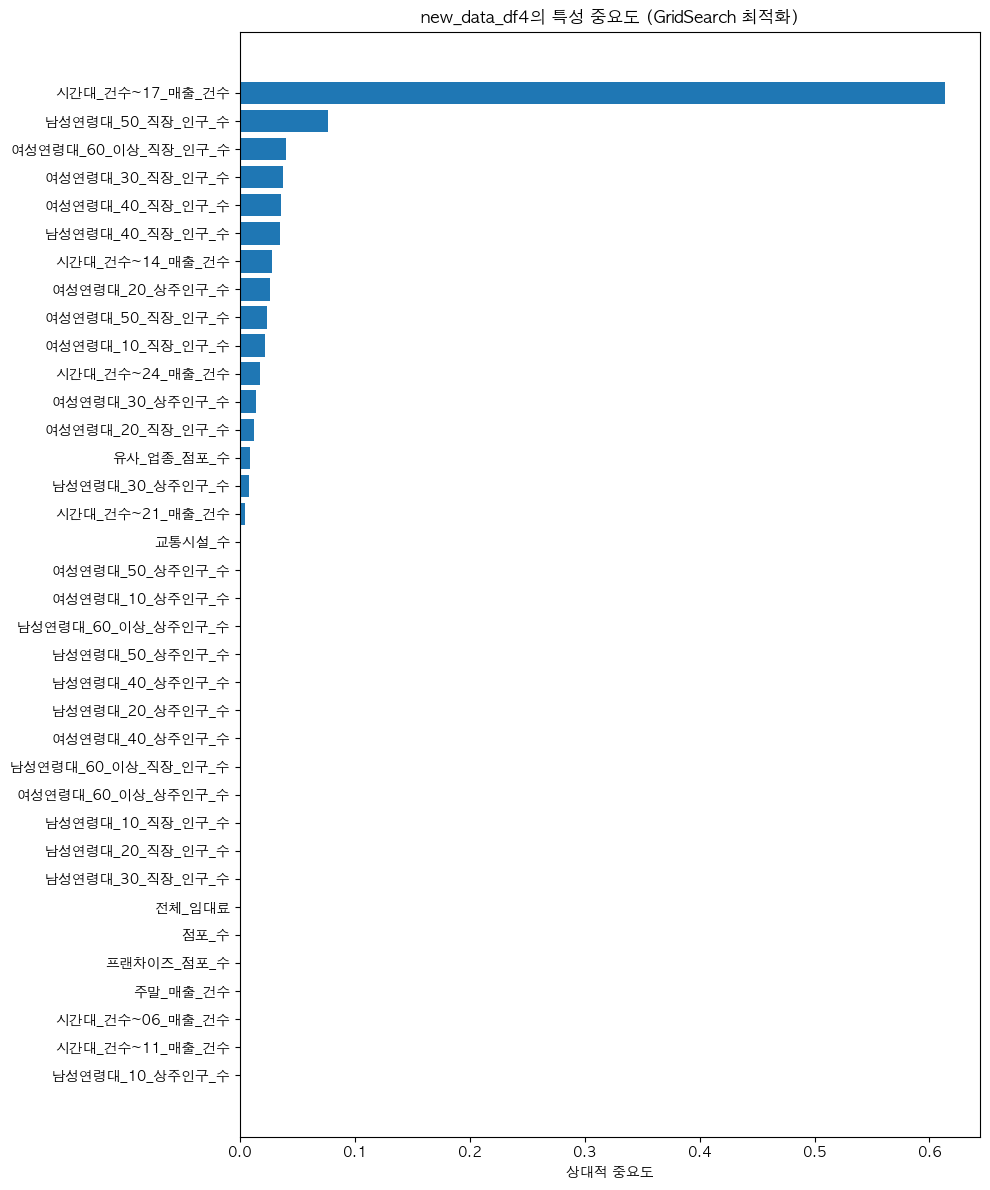

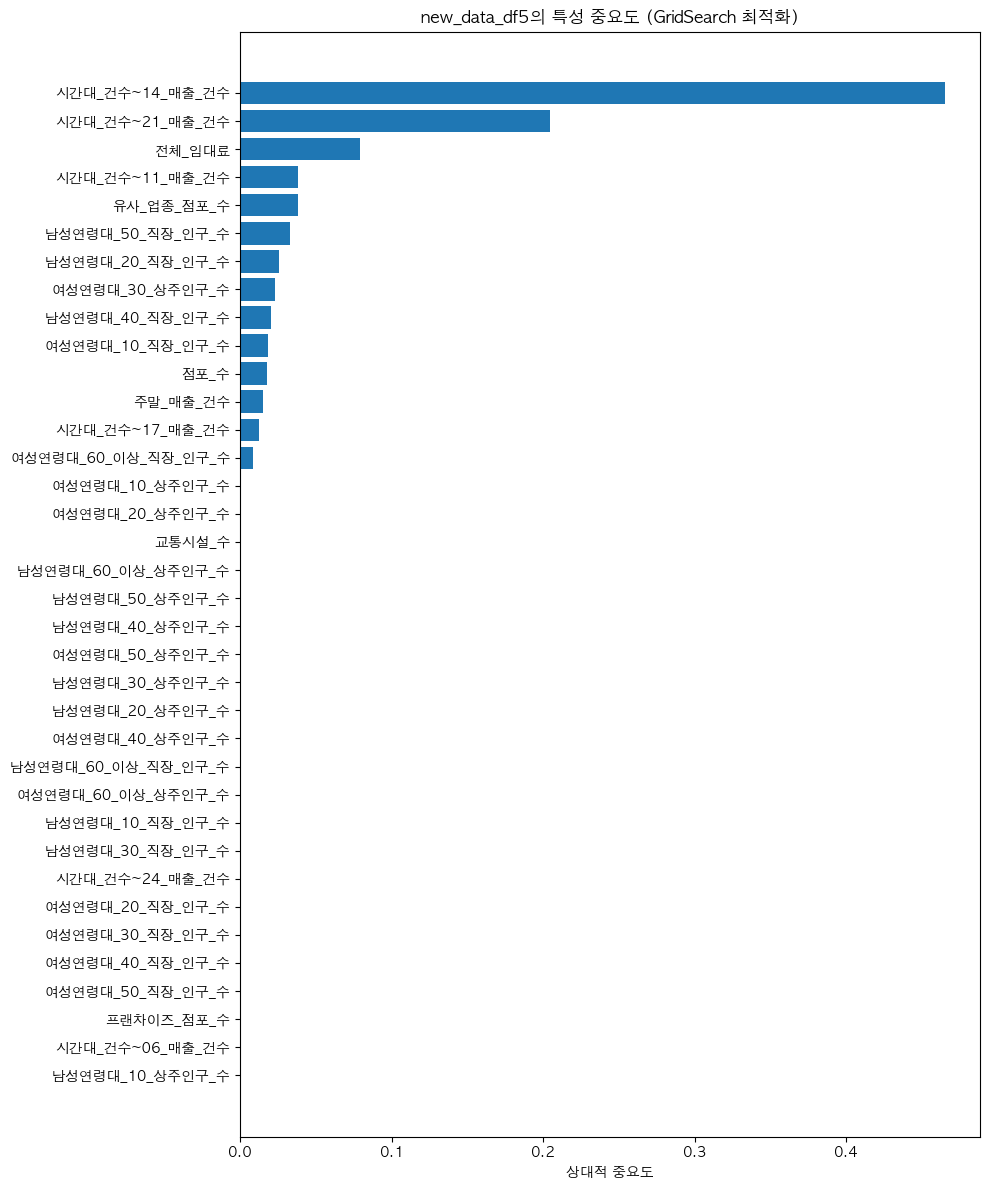

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def get_optimized_model(df):
    # 특성과 목표 변수 선택
    y = df['주중_매출_금액']
    X = df.drop(columns=['주중_매출_금액'])

    # '주중_매출_금액'을 세 개의 범주로 변환
    lower_bound = y.quantile(0.33)
    upper_bound = y.quantile(0.66)
    y = y.apply(lambda x: 0 if x <= lower_bound else (1 if x <= upper_bound else 2))

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 의사 결정 트리 모델 생성
    dt_model = DecisionTreeClassifier(random_state=42)

    # 그리드 서치용 매개변수 그리드 정의
    param_grid = {
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # GridSearchCV 객체 생성
    grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # 데이터에 맞게 학습
    grid_search.fit(X_train, y_train)

    # 최적의 추정기 반환
    return grid_search.best_estimator_

def plot_feature_importance(df, model, title):
    # 특성 중요도 가져오기
    importances = model.feature_importances_
    # 열 이름 가져오기
    columns = df.drop(columns=['주중_매출_금액']).columns
    # 중요도 정렬
    indices = np.argsort(importances)

    plt.figure(figsize=(10, 12))
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [columns[i] for i in indices])
    plt.xlabel('상대적 중요도')
    plt.tight_layout()
    plt.show()

# 각 데이터프레임에 대한 최적화된 모델 가져오고 특성 중요도 그래프 그리기
for i, df in enumerate([new_data_df1, new_data_df2, new_data_df3, new_data_df4, new_data_df5], start=1):
    최적화된_모델 = get_optimized_model(df)
    plot_feature_importance(df, 최적화된_모델, f"new_data_df{i}의 특성 중요도 (GridSearch 최적화)") 

